In [62]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
## Loading the dataset
path='/content/drive/My Drive/Company Stock and Investment.csv'
df=pd.read_csv(path)

In [64]:
df.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [65]:
df=df.drop(['Comp Stock','Gold Investments','Other sharesInvestments'],axis=1)
df

,Date,Oil Investments
0,31-12-2009,0.025417
1,04-01-2010,0.026830
2,05-01-2010,0.002699
3,06-01-2010,0.021688
4,07-01-2010,-0.006256
...,...,...
1979,09-11-2017,0.005984
1980,10-11-2017,-0.007173
1981,13-11-2017,0.000352
1982,14-11-2017,-0.019376


In [66]:
df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.set_index('Date', inplace=True)

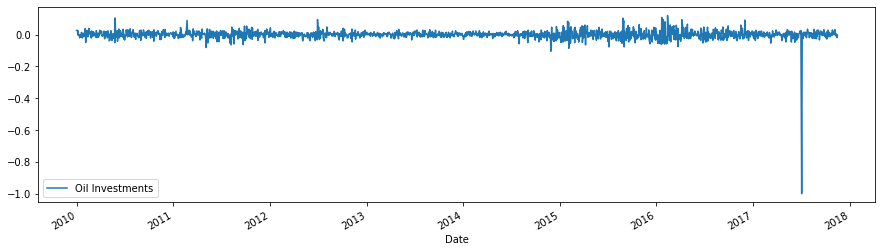

In [67]:
df.plot(figsize=(15,4))

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [69]:
print(df)

[[0.91595072]
 [0.91721237]
 [0.89565756]
 ...
 [0.89356173]
 [0.87593899]
 [0.88698923]]


In [70]:
##splitting dataset into train and test split
training_size=int(len(df)*0.76)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [71]:
training_size,test_size

(1507, 477)

In [72]:
train_data

array([[0.91595072],
       [0.91721237],
       [0.89565756],
       ...,
       [0.93383731],
       [0.90907412],
       [0.91414444]])

In [95]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----29 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [96]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [97]:
print(X_train.shape), print(y_train.shape)

(1406, 100)
(1406,)


(None, None)

In [98]:
print(X_test.shape), print(ytest.shape)

(376, 100)
(376,)


(None, None)

In [99]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [100]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [101]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [102]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
22/22 [==============================] - 1s 58ms/step - loss: 0.0915 - val_loss: 0.0091
Epoch 2/200
22/22 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 3/200
22/22 [==============================] - 0s 17ms/step - loss: 7.8817e-04 - val_loss: 0.0025
Epoch 4/200
22/22 [==============================] - 0s 17ms/step - loss: 3.6880e-04 - val_loss: 0.0025
Epoch 5/200
22/22 [==============================] - 0s 17ms/step - loss: 3.3165e-04 - val_loss: 0.0025
Epoch 6/200
22/22 [==============================] - 0s 17ms/step - loss: 3.2135e-04 - val_loss: 0.0025
Epoch 7/200
22/22 [==============================] - 0s 16ms/step - loss: 3.3484e-04 - val_loss: 0.0025
Epoch 8/200
22/22 [==============================] - 0s 16ms/step - loss: 3.2044e-04 - val_loss: 0.0025
Epoch 9/200
22/22 [==============================] - 0s 16ms/step - loss: 3.1900e-04 - val_loss: 0.0024
Epoch 10/200
22/22 [==============================] - 0s 17ms/step - los

In [104]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [105]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [106]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(ytest,test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(ytest,test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(ytest,test_predict))
print('RMSE: '+str(rmse))

MSE: 0.7770752126491074
MAE: 0.8802002372754008
RMSE: 0.8815186967098925


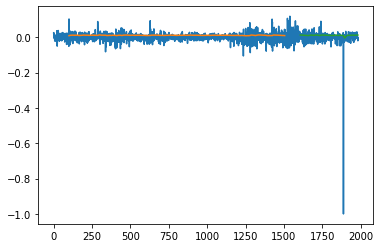

In [107]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [108]:
len(test_data)

477

In [109]:
x_input=test_data[447:].reshape(1,-1)
x_input.shape

(1, 30)

In [110]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [111]:
temp_input

[0.907360231794863,
 0.8677456888901834,
 0.8975918691605055,
 0.9175689017453246,
 0.8997362558024249,
 0.881232498255596,
 0.9077196136188229,
 0.9007152597975111,
 0.8934191724220115,
 0.8963466882991541,
 0.8802043236967377,
 0.8991682400794496,
 0.8980911906215533,
 0.9003020500202846,
 0.8872714638447801,
 0.9008095366515223,
 0.918982532006038,
 0.8963944993410983,
 0.8973739258419825,
 0.8925896479412287,
 0.8970290878645416,
 0.9109317456586128,
 0.9207042779696409,
 0.8909102186577017,
 0.8874679236813825,
 0.898591949316912,
 0.8868398058387021,
 0.8935617310590991,
 0.8759389927853375,
 0.8869892272919552]

In [113]:
# demonstrate prediction for next 2 years
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<775):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

Streaming output truncated to the last 5000 lines.
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641963 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641963 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969]
497 day output [[0.9064197]]
498 day input [0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969
 0.90641969 0.90641969 0.90641969 0.90641969 0.90641969 

In [127]:
day_new=np.arange(1,100)
day_pred=np.arange(101,876)

In [128]:
len(df)

1984

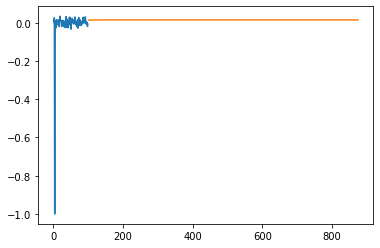

In [129]:
plt.plot(day_new,scaler.inverse_transform(df[1885:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

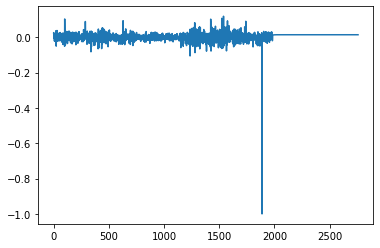

In [130]:
df3=df.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
